Summary: Implement Inverse Distance Weighting (IDW) on two test functions: 
- sine function $$y=\sin x$$
- and Runge function $$y = \frac{1}{1+25x^2}$$

and add confidence bounds and a measurement error. 

## Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator

import seaborn as sns
import scipy.stats as stats

from itertools import combinations
import statistics

## set up Latex rendering (see latex_rendering.ipynb for more info)
import latex_support as latex
plt.style.use('tex')
plt.style.use('seaborn-colorblind')

## Test functions

We define the sine and Runge function. 

In [2]:
def test_function(x, function='runge'): 
    if function=='runge': 
        return runge(x)
    elif function=='sine': 
        return sine(x)
    elif function=='quadratic':
        return quadratic(x)
    else:
        print('Error: Please choose a valid test function. ')
        

def sine(x): 
    """
    calculate y = sin x
    input: x
    ouput: y
    """
    return np.sin(x)

def runge(x): 
    """
    calculate Runge function y = 1 / (1 + 25*x**2)
    input: x
    ouput: y
    """
    return 1/(1+25*x**2)

def quadratic(x):
    """
    calculate quadratic function y = x**2
    input: x
    ouput: y
    """
    return x**2

## Base points and interpolated points

We need a function to draw i values from a range. 

In [99]:
def x_draw(x_min, x_max, i): 
    """
    randomly draw i x-values from range (x_min, x_max)
    input: 
    - x_min: lower limit 
    - x_max: upper limit
    - i: number of values drawn
    ouput: array with i random values
    """
    return np.random.uniform(x_min,x_max,i)

### Estimate derivative variability

https://stackoverflow.com/questions/18201690/get-unique-combinations-of-elements-from-a-python-list

https://www.geeksforgeeks.org/permutation-and-combination-in-python/

https://stackoverflow.com/questions/41821112/how-can-i-sum-the-product-of-two-list-items-using-for-loop-in-python/41821169


In [4]:
def estimate_v(x_base, y_base): 
    comb = combinations(list(range(i_base)), 2)
    weight_ij = []
    slope_squared = []
    for m in list(comb):
        i = m[0]
        j = m[1]
        
        slope = (y_base[i] - y_base[j])**2/(x_base[i] - x_base[j])**2
        slope_squared.append(slope)
        
        weight = 1/(x_base[i] - x_base[j])**2
        weight_ij.append(weight)
    v_upper = sum(x * y for x, y in zip(weight_ij, slope_squared)) 
    v_lower = sum(weight_ij)
    v = v_upper / v_lower
    print('Estimated derivative variability: {:.2f}'.format(v))
    return v


## IDW

We implement IDW with and without measurement error. 

In [111]:
def squared_distance(x_0, x_i):
    """
    calculate the squared distance between two points in 1D
    input: two x-values
    output: squared distance between them
    """
    d = (x_0 - x_i)**2
    return d

def idw_without_error(x_base, y_base, x_idw, v):
    """
    do 1D IDW on a list of x-values and calculate standard error
    input: 
    - x_base: known x-values
    - y_base: known y-values
    - x_idw: x-values to be interpolated
    - v: estimated derivative variability
    output: 
    - y_idw: interpolated y-values
    - se: standard error
    """
    ## create empty lists for interpolated y-values and standard error
    y_idw = []
    se = []

    
    ## loop through x-values to be interpolated
    for i in range(len(x_idw)): 
        
        ## calculate squared distances
        squared_distances = [squared_distance(x_base[j], x_idw[i]) 
                     for j in range(len(x_base))]

        ## calculate and append interpolated y-value
        sum_lower = sum([1/x for x in squared_distances])
        sum_upper = sum([y_base[j]/squared_distances[j] for j in range(len(x_base))])
        y_i = sum_upper / sum_lower
        y_idw.append(y_i)
        
        ## calculate and append standard error
        se_i = np.sqrt(v/(sum(squared_distances)))
        se.append(se_i)
    return y_idw, se


def idw_with_error(x_base, y_base, x_idw, v):
    """
    do 1D IDW on a list of x-values and calculate standard error
    input: 
    - x_base: known x-values
    - y_base: known y-values
    - x_idw: x-values to be interpolated
    - v: estimated derivative variability
    output: 
    - y_idw: interpolated y-values
    - se: standard error
    """
    ## create empty lists for interpolated y-values and standard error
    y_idw = []
    se = []
    
    ## calculate individual error variance for each base point
    error_variance = [(error*y_base[j])**2 for j in range(len(y_base))]
    
    ## loop through x-values to be interpolated
    for i in range(len(x_idw)): 
        
        ## calculate squared distances
        squared_distances = [squared_distance(x_base[j], x_idw[i]) 
                     for j in range(len(x_base))]
                
        ## calulate weights
        weights = [1/(squared_distances[j]*v + error_variance[j]) for j in range(len(x_base))]
        
        ## calculate sum of weights
        sum_weights = sum(weights)
        
        ## calculate and append interpolated y-value
        y_i = sum([weights[j]/sum_weights*y_base[j] for j in range(len(x_base))])
        y_idw.append(y_i)
    
        ## calculate and append standard error
        se_i = 1/np.sqrt(sum_weights)
        se.append(se_i)
    
    return y_idw, se


## User configuration

In [183]:
## choose test function
# function = 'runge' # Runge function
function = 'sine' # sine function
# function = 'quadratic' # quadratic function

## configure function plot
x_lower = -np.pi # lower limit of x-axis
x_upper = np.pi # upper limit of x-axis
y_lower = -1.2
y_upper = 1.2
i_function = 1000 # number of points

## configure number of base points drawn
i_base = 50

## configure number of points to interpolate
i_idw = 10

## configure measurement error
error = 0.05

## configure confidence interval
ci = .9 # other option: 0.95

## configure plot
base=0.5*np.pi # distance between ticks (only for sine plot)





## Run and plot

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html

https://www.google.com/search?client=firefox-b-d&q=error+bound

https://note.nkmk.me/en/python-function-return-multiple-values/

Estimated derivative variability: 0.79


C:\Users\awsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-+" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\awsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-+" (-> linestyle='-'). The keyword argument will take precedence.
C:\Users\awsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-+" (-> linestyle='-'). The keyword argument will take precedence.


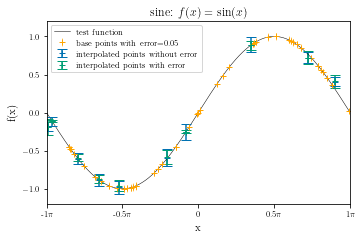

In [184]:
## choose base points (optionally from saved data)
x_base = x_draw(x_lower, x_upper, i_base) # use this to create new points
# x_base = x_base_sine # use this to load old sine data
# x_base = x_base_runge # use this to load old Runge data


## choose interpolated points (optionally from saved data)
x_idw = x_draw(x_lower, x_upper, i_idw) # use this to create new points
# x_idw = x_idw_sine # use this to load old sine data
# x_idw = x_idw_runge # use this to load old Runge data

## calculate function
x = np.linspace(x_lower, x_upper, i_function)
y = test_function(x, function)

## calculate y-values of base points
y_base = test_function(x_base, function)
y_base_error = [error*y for y in y_base]

## estimate derivative variability
v = estimate_v(x_base, y_base)

## do IDW (without measurement error)
results_idw_without_error = idw_without_error(x_base, y_base, x_idw, v)
y_idw_without_error = results_idw_without_error[0]
y_idw_se_without_error = results_idw_without_error[1]

## do IDW (with measurement error)
results_idw_with_error = idw_with_error(x_base, y_base, x_idw, v)
y_idw_with_error = results_idw_with_error[0]
y_idw_se_with_error = results_idw_with_error[1]


## calculate error bound from standard error (without and with measurement error)
if ci == 0.9: 
    y_idw_err_without_error = [1.645*x for x in y_idw_se_without_error]
    y_idw_err_with_error = [1.645*x for x in y_idw_se_with_error]
elif ci == 0.95: 
    y_idw_err_without_error = [1.96*x for x in y_idw_se_without_error]
    y_idw_err_with_error = [1.96*x for x in y_idw_se_with_error]
else: 
    print('Error: Please choose a valid confidence interval!')


########

## create plot
fig, ax = plt.subplots(1, 1, figsize=latex.set_size())

## plot test function
ax.plot(x, y, color='black', linewidth=0.5, label='test function')

## plot base points
ax.errorbar(x_base, y_base, yerr=y_base_error, fmt='-+',   ls='none', 
           color='orange',  elinewidth=0.5, label='base points with error={}'.format(error))

## plot interpolated points without measurement error
ax.errorbar(x_idw, y_idw_without_error, yerr=y_idw_err_without_error, fmt='-+', ls='none', capsize=5, 
          label='interpolated points without error')

## plot interpolated points with measurement error
ax.errorbar(x_idw, y_idw_with_error, yerr=y_idw_err_with_error, fmt='-+', ls='none', capsize=5,  
             label='interpolated points with error')

## set x-axis ticks for sine plot and change base to change distance between ticks
if function=='sine': 
    ax.xaxis.set_major_formatter(FuncFormatter(
        lambda val,pos: '{:.2g}$\pi$'.format(val/np.pi) if val !=0 else '0'
    ))
    ax.xaxis.set_major_locator(MultipleLocator(base)) 

## set x limits
plt.xlim(x_lower, x_upper)
plt.ylim(y_lower, y_upper)

## set title, labels and legend
if function=='sine': 
    plt.title(r'sine: $f(x) = \sin(x)$')
elif function=='runge': 
    plt.title(r'Runge: $f(x) = \frac{1}{1+25x^2}$')
elif function=='quadratic':
    plt.title(r'quadratic: $f(x) = x^2$')
else:
    print('Error: Please choose a valid test function!')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

Save the base points and interpolated points for later. 

In [19]:
## Store Runge data
x_base_runge = x_base
x_idw_runge = x_idw
%store x_base_runge
%store x_idw_runge


Stored 'x_base_runge' (ndarray)
Stored 'x_idw_runge' (ndarray)


In [135]:
## Load Runge data
%store -r x_base_runge
%store -r x_idw_runge

In [186]:
## Store sine data
x_base_sine = x_base
x_idw_sine = x_idw
%store x_base_sine
%store x_idw_sine

Stored 'x_base_sine' (ndarray)
Stored 'x_idw_sine' (ndarray)


In [187]:
## Load sine data
%store -r x_base_sine
%store -r x_idw_sine

To evaluate the IDW, calculate and save the mean squared error. 

In [188]:
## calculate MSE
y_exact = test_function(x_idw)
mse = np.mean(squared_distance(y_idw, y_exact))

In [189]:
## use this for sine
mse_sine = mse
%store mse_sine

Stored 'mse_sine' (float64)


In [21]:
## use this for Runge
mse_runge = mse
%store mse_runge

Stored 'mse_runge' (float64)


To retrieve the last MSEs: 

https://www.blopig.com/blog/2020/05/storing-variables-in-jupyter-notebooks-using-store-magic/

In [190]:
%store -r mse_sine
print('MSE for the sine: ', mse_sine)

MSE for the sine:  0.37653699996229645


In [22]:
%store -r mse_runge
print('MSE for Runge: ', mse_runge)

MSE for Runge:  0.08343070386675819


We save the plots and dataframe. 

In [161]:
if function=='sine': 
    fig.savefig('theo3a_sine.pdf', bbox_inches='tight')
    df.to_pickle('theo3a_sine_results')
if function=='runge': 
    fig.savefig('theo3b_runge.pdf', bbox_inches='tight')
    df.to_pickle('theo3b_runge_results')

In [185]:
fig.savefig('theo3a_sine_error5%.pdf', bbox_inches='tight')